We first connect to our database. <br>
For practice or table analysis, please see the Jupyter Notebook for Checking SQL Data.

In [1]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import queue
import random
import collections

database = "sdow.sqlite"
connection = sql.connect(database)

query_pages = '''SELECT * FROM pages'''
df = pd.read_sql_query(query_pages, connection)

<b>1 Degree of Separation:</b><br>
18978754	Apple To 10031955	Spartan_(apple)	<br>
<br> 
<b>2 Degrees of Separation:</b><br>
477917      Lemur To 378661     Thermoregulation <br>

<b>3 Degrees of Separation</b><br>
11271498 Egress To 34368 Yellow

Here we have a naive Breadth First Search. Given enough time we are assured at least the shortest path. <br>
We continue searching past the shortest path to find as many paths as possible within i iterations. <br>
However, this algorithm is extremely inefficient and has trouble finding connected paths for even
3 Degrees of Separation.

In [2]:
def BFS(start, end):
    queue = collections.deque()
    startid = getIDFromTitle(start)
    endid = getIDFromTitle(end)
    
    if queryExistenceFromID(startid) == False: return []   
    if queryExistenceFromID(endid) == False: return []
    
    all_valid_paths = list()
    visited = [False] * (len(df)) 
    
    print_path = [getTitle(startid)]
    temp_path = [startid]
    queue.append(temp_path)
    
    visited[hashForIndex(temp_path[0])] = True
    
    i=0
    while queue and i<5000:
        tmp_path = queue.popleft()
        last_node = tmp_path[len(tmp_path)-1]
        visited[hashForIndex(last_node)] = True
        
        if str(last_node) == str(endid):
            all_valid_paths.append(tmp_path)
            print("VALID_PATH : ",getTitles(tmp_path))
        for neighbor in getOutgoingNeighbors(last_node):
            if neighbor not in tmp_path and visited[hashForIndex(int(neighbor))]==False:
                new_path = []
                new_path = tmp_path + [neighbor]
                queue.append(new_path)
        i=i+1
    return all_valid_paths

Here is an implementation for a Multidirectional Breadth First Search. <br><br>
We search from both the start and end of our query. When these searches meet in the middle they are <br>
concatenated together. This process continues for i iterations to find as many paths as possible. <br>
We are not guaranteed <b>every</b> path as Wikipedia's data is circular by nature and can provide an infinite<br>
number of paths.

In [3]:
def multiBFS(start, end):    
    startq = collections.deque()
    endq = collections.deque()
    
    startid = getIDFromTitle(start)
    endid = getIDFromTitle(end)
     
    if startid == endid: return [start]    
    if queryExistenceFromID(startid) == False: return []   
    if queryExistenceFromID(endid) == False: return []

    all_valid_paths = list()
    
    fwd_visited = [False] * (len(df)) 
    back_visited = [False] * (len(df))
    
    temp_path_start = [startid]
    temp_path_end = [endid]
    
    startq.append(temp_path_start)
    endq.append(temp_path_end)
    
    fwd_visited[hashForIndex(int(temp_path_start[0]))] = True
    back_visited[hashForIndex(int(temp_path_end[0]))] = True
    
    i=0
    while startq and endq and i<50:
        if len(startq)<=len(endq):
            if startq:
                tmp_path_start = startq.popleft()
                last_node = tmp_path_start[len(tmp_path_start)-1]
                fwd_visited[int(hashForIndex(last_node))] = True
                if str(last_node) == str(endid) or last_node in endq:
                    all_valid_paths.append(tmp_path_start)
                    print("A_VALID_PATH : ",getTitles(tmp_path_start))

                for neighbor in getOutgoingNeighbors(last_node):
                    if neighbor not in tmp_path_start and fwd_visited[hashForIndex(int(neighbor))]==False:
                        new_path = []
                        new_path = tmp_path_start + [neighbor]
                        startq.append(new_path)
        
        else:
            if endq:
                tmp_path_end = endq.popleft()
                last_node = tmp_path_end[len(tmp_path_end)-1]
                back_visited[int(hashForIndex(last_node))] = True
                if str(last_node) == str(startid) or last_node in startq:
                    all_valid_paths.append(tmp_path_end)
                    print("B_VALID_PATH : ",getTitles(tmp_path_end))

                for neighbor in getIncomingNeighbors(last_node):
                    if neighbor not in tmp_path_end and back_visited[hashForIndex(int(neighbor))]==False:
                        new_path = []
                        new_path = tmp_path_end + [neighbor]
                        endq.append(new_path)
                
        i=i+1
    return all_valid_paths

We have a collection of helper methods for querying our database. We conveniently have acess to neighbors,<br>
titles, IDs, ect..

In [4]:
def hashForIndex(id):
    return hash(id) % len(df)

#Takes in the current ID and the database. Returns the list of neighbors.
def getOutgoingNeighbors(current):
    neighborList = []
    link = '''SELECT * FROM links WHERE id = ''' + str(current)
    neigh = pd.read_sql_query(link, connection)
    neighbors = neigh.iloc[0]['outgoing_links']
    
    neighbor = ""
    for char in neighbors:
        if char != '|':
            neighbor+=char
        else:
            neighborList.append(neighbor)
            neighbor = ""
    return neighborList

def getIncomingNeighbors(current):
    neighborList = []
    link = '''SELECT * FROM links WHERE id = ''' + str(current)
    neigh = pd.read_sql_query(link, connection)
    neighbors = neigh.iloc[0]['incoming_links']
    
    neighbor = ""
    for char in neighbors:
        if char != '|':
            neighbor+=char
        else:
            neighborList.append(neighbor)
            neighbor = ""
    return neighborList

def checkQueueForElement(queue, query):
    element_found = False 
    temp_queue = queue
    this_queue = queue
    for element in range(this_queue.qsize()):
        check = this_queue.get()
        print(str(check[0]))
        print(str(query))
        if str(check[0]) == str(query):
            element_found=True
    return element_found

def getTitle(query):
    query_string = '''SELECT * FROM pages WHERE id = ''' + str(query)
    title = pd.read_sql_query(query_string, connection)
    cleaned_title = title.iloc[0]['title']
    return cleaned_title

def getTitles(querys):
    cleaned_querys = list()
    for query in querys:
        query_string = '''SELECT * FROM pages WHERE id = ''' + str(query)
        title = pd.read_sql_query(query_string, connection)
        cleaned_title = title.iloc[0]['title']
        cleaned_querys.append(cleaned_title)
        
    return cleaned_querys

def getIDFromTitle(title):
    try:
        query = '''SELECT * FROM pages where title = ''' + "'" +str(title) + "'"
        queryID = pd.read_sql_query(query, connection)
        returnID = queryID.iloc[0]['id']
        return returnID
    except:
        print(title + " does not exist!")

def queryExistenceFromID(query):
    try:
        existence = False
        query_string = '''SELECT * FROM pages WHERE id = ''' + str(query)
        answer = pd.read_sql_query(query_string, connection)

        if len(answer) != 0: existence = True

        return existence
    except: 
        return False

Our queries accept a String input. <br>
Notice, we output a list of path ID's. This is more efficient then converting the ID back to <br>
the title at this step.

In [5]:
start = 'Apple' 
end = 'Spartan_(apple)'
valid_paths = multiBFS(start, end)
print(valid_paths)

C:\Users\Austin\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


A_VALID_PATH :  ['Apple', 'Spartan_(apple)']
[[18978754, '10031955']]


In [6]:
valid_paths = BFS('Apple', 'Spartan_(apple)')

VALID_PATH :  ['Apple', 'Spartan_(apple)']
VALID_PATH :  ['Apple', 'Applejack_(drink)', 'Spartan_(apple)']
VALID_PATH :  ['Apple', 'Pinova', 'Spartan_(apple)']
VALID_PATH :  ['Apple', 'Cameo_(apple)', 'Spartan_(apple)']
VALID_PATH :  ['Apple', 'Red_Delicious', 'Spartan_(apple)']


Getting a collection of valid paths is nice, but it would be more descriptive if we could see the paths. <br>
Below we use the networkx library to visualize our graph. We use a Directed Graph to display the direct <br>
paths from our start to our finish!

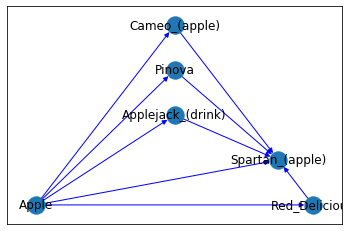

<Figure size 864x864 with 0 Axes>

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import array as arr 
G = nx.DiGraph()
            
for path in valid_paths:
    titled_paths = getTitles(path)

    for index, title in enumerate(titled_paths[:-1]):
        G.add_edges_from([(title, titled_paths[index+1])])

pos = nx.planar_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, arrows=True,edge_color='b')
plt.figure(3,figsize=(12,12))
plt.show()



Visualizing the data inside a Jupyter Notebook file can be difficult. It would be nice if we could <br>
at least zoom in on our data and have our nodes more spread out. The below function takes a graph <br>
and saves it to a PDF file. This way large graphs are a little easier to see.

In [9]:
 def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(40, 40), dpi=8)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.planar_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 2
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(-10, xmax+10)
    plt.ylim(-10, ymax+10)

    plt.savefig(file_name)
    plt.close()
    del fig



In [10]:
save_graph(G,"my_graph.pdf")

### Below is an implementation for this project created by Jacob Wenger

This was not the inspiration for this project, but I came across this work while researching for my own project. This is a very clean and extremely efficient implementation that does a lot of the things I tried to complete in this project. The project code below must be run and then we show some examples and measure the efficiency of this algorithm. <br><br>
This is a multidirectional BFS on the wikipedia database.

Github: https://github.com/jwngr/sdow/blob/master/sdow/breadth_first_search.py <br>
Website: https://www.sixdegreesofwikipedia.com/ 

In [3]:
def get_paths(page_ids, visited_dict):
  """Returns a list of paths which go from the provided pages to either the source or target pages.
  Args:
    page_ids: The list of page IDs whose paths to get.
  Returns:
    list(list(int)): A list of lists of page IDs corresponding to paths from the provided page IDs
      to the source or target pages.
  """
  paths = []

  for page_id in page_ids:
    if page_id is None:
      # If the current page ID is None, it is either the source or target page, so return an empty
      # path.
      return [[]]
    else:
      # Otherwise, recursively get the paths for the current page's children and append them to
      # paths.
      current_paths = get_paths(visited_dict[page_id], visited_dict)
      for current_path in current_paths:
        new_path = list(current_path)
        new_path.append(page_id)
        paths.append(new_path)

  return paths


def breadth_first_search(source_page_id, target_page_id, database):
  """Returns a list of shortest paths from the source to target pages by running a bi-directional
  breadth-first search on the graph of Wikipedia pages.
  Args:
    source_page_id: The page at which to start the search.
    target_page_id: The page at which to end the search.
    database: An Database instance which contains methods to query the Wikipedia database.
  Returns:
    list(list(int)): A list of lists of page IDs corresponding to paths from the source page to the
      target page.
  """
  # If the source and target page IDs are identical, return the trivial path.
  if source_page_id == target_page_id:
    return [[source_page_id]]

  paths = []

  # The unvisited dictionaries are a mapping from page ID to a list of that page's parents' IDs.
  # None signifies that the source and target pages have no parent.
  unvisited_forward = {source_page_id: [None]}
  unvisited_backward = {target_page_id: [None]}

  # The visited dictionaries are a mapping from page ID to a list of that page's parents' IDs.
  visited_forward = {}
  visited_backward = {}

  # Set the initial forward and backward depths to 0.
  forward_depth = 0
  backward_depth = 0

  # Continue the breadth first search until a path has been found or either of the unvisited lists
  # are empty.
  while (len(paths) == 0) and ((len(unvisited_forward) != 0) and (len(unvisited_backward) != 0)):
    # Run the next iteration of the breadth first search in whichever direction has the smaller number
    # of links at the next level.
    forward_links_count = database.fetch_outgoing_links_count(unvisited_forward.keys())
    backward_links_count = database.fetch_incoming_links_count(unvisited_backward.keys())

    if forward_links_count < backward_links_count:
      #---  FORWARD BREADTH FIRST SEARCH  ---#
      forward_depth += 1

      # Fetch the pages which can be reached from the currently unvisited forward pages.
      # The replace() bit is some hackery to handle Python printing a trailing ',' when there is
      # only one key.
      outgoing_links = database.fetch_outgoing_links(unvisited_forward.keys())

      # Mark all of the unvisited forward pages as visited.
      for page_id in unvisited_forward:
        visited_forward[page_id] = unvisited_forward[page_id]

      # Clear the unvisited forward dictionary.
      unvisited_forward.clear()

      for source_page_id, target_page_ids in outgoing_links:
        for target_page_id in target_page_ids.split('|'):
          if target_page_id:
            target_page_id = int(target_page_id)
            # If the target page is in neither visited forward nor unvisited forward, add it to
            # unvisited forward.
            if (target_page_id not in visited_forward) and (target_page_id not in unvisited_forward):
              unvisited_forward[target_page_id] = [source_page_id]

            # If the target page is in unvisited forward, add the source page as another one of its
            # parents.
            elif target_page_id in unvisited_forward:
              unvisited_forward[target_page_id].append(source_page_id)

    else:
      #---  BACKWARD BREADTH FIRST SEARCH  ---#
      backward_depth += 1

      # Fetch the pages which can reach the currently unvisited backward pages.
      incoming_links = database.fetch_incoming_links(unvisited_backward.keys())

      # Mark all of the unvisited backward pages as visited.
      for page_id in unvisited_backward:
        visited_backward[page_id] = unvisited_backward[page_id]

      # Clear the unvisited backward dictionary.
      unvisited_backward.clear()

      for target_page_id, source_page_ids in incoming_links:
        for source_page_id in source_page_ids.split('|'):
          if source_page_id:
            source_page_id = int(source_page_id)
            # If the source page is in neither visited backward nor unvisited backward, add it to
            # unvisited backward.
            if (source_page_id not in visited_backward) and (source_page_id not in unvisited_backward):
              unvisited_backward[source_page_id] = [target_page_id]

            # If the source page is in unvisited backward, add the target page as another one of its
            # parents.
            elif source_page_id in unvisited_backward:
              unvisited_backward[source_page_id].append(target_page_id)

    #---  CHECK FOR PATH COMPLETION  ---#
    # The search is complete if any of the pages are in both unvisited backward and unvisited, so
    # find the resulting paths.
    for page_id in unvisited_forward:
      if page_id in unvisited_backward:
        paths_from_source = get_paths(unvisited_forward[page_id], visited_forward)
        paths_from_target = get_paths(unvisited_backward[page_id], visited_backward)

        for path_from_source in paths_from_source:
          for path_from_target in paths_from_target:
            current_path = list(path_from_source) + [page_id] + list(reversed(path_from_target))

            # TODO: This line shouldn't be required, but there are some unexpected duplicates.
            if current_path not in paths:
              paths.append(current_path)

  return paths

A Database class created with helpers that fetch database information.

In [4]:
"""
Wrapper for reading from and writing to the SDOW database.
"""

import os.path
import sqlite3


class Database(object):
  """Wrapper for connecting to the SDOW database."""

  def __init__(self, sdow_database, searches_database):
    if not os.path.isfile(sdow_database):
      raise IOError('Specified SQLite file "{0}" does not exist.'.format(sdow_database))

    if not os.path.isfile(searches_database):
      raise IOError('Specified SQLite file "{0}" does not exist.'.format(searches_database))

    self.sdow_conn = sqlite3.connect(sdow_database, check_same_thread=False)
    self.searches_conn = sqlite3.connect(searches_database, check_same_thread=False)

    self.sdow_cursor = self.sdow_conn.cursor()
    self.searches_cursor = self.searches_conn.cursor()

    self.sdow_cursor.arraysize = 1000
    self.searches_cursor.arraysize = 1000

  def fetch_page(self, page_title):
    """Returns the ID and title of the non-redirect page corresponding to the provided title,
    handling titles with incorrect capitalization as well as redirects.
    Args:
      page_title: The title of the page to fetch.
    Returns:
      (int, str, bool): A tuple containing the page ID, title, and whether or not a redirect was
      followed.
      OR
      None: If no page exists.
    Raises:
      ValueError: If the provided page title is invalid.
    """
    sanitized_page_title = helpers.get_sanitized_page_title(page_title)

    query = 'SELECT * FROM pages WHERE title = ? COLLATE NOCASE;'
    query_bindings = (sanitized_page_title,)
    self.sdow_cursor.execute(query, query_bindings)

    # Because the above query is case-insensitive (due to the COLLATE NOCASE), multiple articles
    # can be matched.
    results = self.sdow_cursor.fetchall()

    if not results:
      raise ValueError(
          'Invalid page title {0} provided. Page title does not exist.'.format(page_title))

    # First, look for a non-redirect page which has exact match with the page title.
    for current_page_id, current_page_title, current_page_is_redirect in results:
      if current_page_title == sanitized_page_title and not current_page_is_redirect:
        return (current_page_id, helpers.get_readable_page_title(current_page_title), False)

    # Next, look for a match with a non-redirect page.
    for current_page_id, current_page_title, current_page_is_redirect in results:
      if not current_page_is_redirect:
        return (current_page_id, helpers.get_readable_page_title(current_page_title), False)

    # If all the results are redirects, use the page to which the first result redirects.
    query = 'SELECT target_id, title FROM redirects INNER JOIN pages ON pages.id = target_id WHERE source_id = ?;'
    query_bindings = (results[0][0],)
    self.sdow_cursor.execute(query, query_bindings)

    result = self.sdow_cursor.fetchone()

    # TODO: This will no longer be required once the April 2018 database dump occurs since this
    # scenario is prevented by the prune_pages_file.py Python script during the database creation.
    if not result:
      raise ValueError(
          'Invalid page title {0} provided. Page title does not exist.'.format(page_title))

    return (result[0], helpers.get_readable_page_title(result[1]), True)

  def fetch_page_title(self, page_id):
    """Returns the page title corresponding to the provided page ID.
    Args:
      page_id: The page ID whose ID to fetch.
    Returns:
      str: The page title corresponding to the provided page ID.
    Raises:
      ValueError: If the provided page ID is invalid or does not exist.
    """
    helpers.validate_page_id(page_id)

    query = 'SELECT title FROM pages WHERE id = ?;'
    query_bindings = (page_id,)
    self.sdow_cursor.execute(query, query_bindings)

    page_title = self.sdow_cursor.fetchone()

    if not page_title:
      raise ValueError(
          'Invalid page ID "{0}" provided. Page ID does not exist.'.format(page_id))

    return page_title[0].encode('utf-8').replace('_', ' ')

  def compute_shortest_paths(self, source_page_id, target_page_id):
    """Returns a list of page IDs indicating the shortest path between the source and target pages.
    Note: the provided page IDs must correspond to non-redirect pages, but that check is not made
    for performance reasons.
    Args:
      source_page_id: The ID corresponding to the page at which to start the search.
      target_page_id: The ID corresponding to the page at which to end the search.
    Returns:
      list(list(int)): A list of integer lists corresponding to the page IDs indicating the shortest path
        between the source and target page IDs.
    Raises:
      ValueError: If either of the provided page IDs are invalid.
    """
    helpers.validate_page_id(source_page_id)
    helpers.validate_page_id(target_page_id)

    return breadth_first_search(source_page_id, target_page_id, self)

  def fetch_outgoing_links_count(self, page_ids):
    """Returns the sum of outgoing links of the provided page IDs.
    Args:
      page_ids: A list of page IDs whose outgoing links to count.
    Returns:
      int: The count of outgoing links.
    """
    return self.fetch_links_count_helper(page_ids, 'outgoing_links_count')

  def fetch_incoming_links_count(self, page_ids):
    """Returns the sum of incoming links for the provided page IDs.
    Args:
      page_ids: A list of page IDs whose incoming links to count.
    Returns:
      int: The count of incoming links.
    """
    return self.fetch_links_count_helper(page_ids, 'incoming_links_count')

  def fetch_links_count_helper(self, page_ids, incoming_or_outgoing_links_count):
    """Returns the sum of outgoing or incoming links for the provided page IDs.
    Args:
      page_ids: A list of page IDs whose outgoing or incoming links to count.
    Returns:
      int: The count of outgoing or incoming links.
    """
    page_ids = str(tuple(page_ids)).replace(',)', ')')

    # There is no need to escape the query parameters here since they are never user-defined.
    query = 'SELECT SUM({0}) FROM links WHERE id IN {1};'.format(
        incoming_or_outgoing_links_count, page_ids)
    self.sdow_cursor.execute(query)

    return self.sdow_cursor.fetchone()[0]

  def fetch_outgoing_links(self, page_ids):
    """Returns a list of tuples of page IDs representing outgoing links from the list of provided
    page IDs to other pages.
    Args:
      page_ids: A list of page IDs whose outgoing links to fetch.
    Returns:
      list(int, int): A lists of integer tuples representing outgoing links from the list of
        provided page IDs to other pages.
    """
    return self.fetch_links_helper(page_ids, 'outgoing_links')

  def fetch_incoming_links(self, page_ids):
    """Returns a list of tuples of page IDs representing incoming links from the list of provided
    page IDs to other pages.
    Args:
      page_ids: A list of page IDs whose incoming links to fetch.
    Returns:
      list(int, int): A lists of integer tuples representing incoming links from the list of
        provided page IDs to other pages.
    """
    return self.fetch_links_helper(page_ids, 'incoming_links')

  def fetch_links_helper(self, page_ids, outcoming_or_incoming_links):
    """Helper function which handles duplicate logic for fetch_outgoing_links() and
    fetch_incoming_links().
    Args:
      page_ids: A list of page IDs whose links to fetch.
      outcoming_or_incoming_links: String which indicates whether to fetch outgoing ("source_id") or
        incoming ("target_id") links.
    Returns:
      list(int, int): A cursor of a lists of integer tuples representing links from the list of
        provided page IDs to other pages.
    """
    # Convert the page IDs into a string surrounded by parentheses for insertion into the query
    # below. The replace() bit is some hackery to handle Python printing a trailing ',' when there
    # is only one key.
    page_ids = str(tuple(page_ids)).replace(',)', ')')

    # There is no need to escape the query parameters here since they are never user-defined.
    query = 'SELECT id, {0} FROM links WHERE id IN {1};'.format(
        outcoming_or_incoming_links, page_ids)
    self.sdow_cursor.execute(query)

    return self.sdow_cursor

  def insert_result(self, search):
    """Inserts a new search result into the searches table.
    Args:
      results: A dictionary containing search information.
    Returns: 
      None
    """
    paths_count = len(search['paths'])

    if paths_count == 0:
      degrees_count = 'NULL'
    else:
      degrees_count = len(search['paths'][0]) - 1

    # There is no need to escape the query parameters here since they are never user-defined.
    query = 'INSERT INTO searches VALUES ({source_id}, {target_id}, {duration}, {degrees_count}, {paths_count}, CURRENT_TIMESTAMP);'.format(
        source_id=search['source_id'],
        target_id=search['target_id'],
        duration=search['duration'],
        degrees_count=degrees_count,
        paths_count=paths_count,
    )
    self.searches_conn.execute(query)
    self.searches_conn.commit()



Now that we have loaded in all of our functions, lets go for an example. <br> <br>
11271498 Egress To 34368 Yellow <br><br>
All we need is to apply an id infor the breadth first search implementation.

In [5]:
newdb = Database(database,database)
breadth_first_search(11271498, 34368, newdb)

[[11271498, 46380, 31990, 34368],
 [11271498, 46380, 42852, 34368],
 [11271498, 46380, 98132, 34368]]

This provides as many close paths as possible in string id form and runs extremely quickly. Let us use the graph implementation we used in Part A to display.

C:\Users\Austin\Anaconda3\lib\site-packages\networkx\drawing\layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))
C:\Users\Austin\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\Austin\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


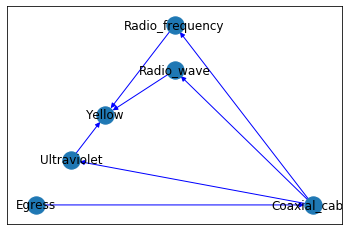

<Figure size 864x864 with 0 Axes>

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import array as arr 

valid_paths = breadth_first_search(11271498, 34368, newdb)
G = nx.DiGraph()
            
for path in valid_paths:
    titled_paths = getTitles(path)

    for index, title in enumerate(titled_paths[:-1]):
        G.add_edges_from([(title, titled_paths[index+1])])

pos = nx.planar_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, arrows=True,edge_color='b')
plt.figure(3,figsize=(12,12))
plt.show()

As before, we can save the image by using our save graph function for graph G generated before.

In [15]:
save_graph(G,"my_graph.pdf")

Now let us check some interesting metrics for the fast implementation of the BFS algorithm. We start by getting a random collection of 5 words in our database. We get all permutations of these items for about 20 queries total.

In [16]:
query_pages = '''SELECT * FROM pages WHERE is_redirect=0'''
df = pd.read_sql_query(query_pages, connection)

In [17]:
wordselection = df.sample(n = 5)
wordselection.head()

,id,title,is_redirect
142356,311431,Joseph_Thompson,0
2337177,18944370,Doug_Boyd,0
3200602,28159310,Short_Circuit_II_(album),0
3876873,36270080,Tylosis_hilaris,0
3846333,35974688,WTIM,0


We get every possible permutations of words to search.

In [18]:
import itertools
word_combinations = list(itertools.permutations(wordselection['id'], 2))
len(word_combinations)

20

We will iterate over all permutations of beginning and ending paths. 100,000 total items should take about 13 hours.

In [20]:
import time
index = 0
data = []
for combination in word_combinations:
    start = time.perf_counter()
    valid_paths = breadth_first_search(combination[0], combination[1], newdb)
    end = time.perf_counter() 
    begin = getTitle(combination[0])
    goal = getTitle(combination[1])
    if valid_paths:
        data.append([combination, begin, goal, len(valid_paths),valid_paths, len(valid_paths[0]),valid_paths[0], 
                      end-start])
    else:
        data.append([combination, begin, goal, len(valid_paths),valid_paths, 0,[], 
                      end-start])

Now that we have generated some metrics, we can examine the distribution of path links. <br>
We put our results into a dataframe for easy analysis.

In [21]:
analysis = pd.DataFrame(data, columns = ['Combination','Start Title','Goal Title','Paths Found', 
                                         'All Paths', 'Shortest Path Length', 'Shortest Path',
                                        'Time Taken']) 

In [22]:
analysis.head()

,Combination,Start Title,Goal Title,Paths Found,All Paths,Shortest Path Length,Shortest Path,Time Taken
0,"(311431, 18944370)",Joseph_Thompson,Doug_Boyd,1,"[[311431, 54673095, 6484538, 20595373, 18944370]]",5,"[311431, 54673095, 6484538, 20595373, 18944370]",0.017822
1,"(311431, 28159310)",Joseph_Thompson,Short_Circuit_II_(album),1,"[[311431, 52934078, 528282, 147778, 2768827, 2...",6,"[311431, 52934078, 528282, 147778, 2768827, 28...",0.071939
2,"(311431, 36270080)",Joseph_Thompson,Tylosis_hilaris,383,"[[311431, 37237849, 307, 18023, 518913, 186667...",9,"[311431, 37237849, 307, 18023, 518913, 1866675...",2.020500
3,"(311431, 35974688)",Joseph_Thompson,WTIM,0,[],0,[],0.001044
4,"(18944370, 311431)",Doug_Boyd,Joseph_Thompson,36,"[[18944370, 27766, 19009060, 72243, 18969184, ...",6,"[18944370, 27766, 19009060, 72243, 18969184, 3...",0.890053


Below we save our dataframe to a csv for future analysis. 

In [23]:
analysis.to_csv(r'C:\Users\Austin\Desktop\permutations2.csv', index = False)

Let us also consider an alternate way of selecting articles. Previously we only were able to use 350 articles with their permutations. Combinations are less interesting because we end up with a lot of the same initial path. Let's try using a larger number of articles but only pairing them once (1000 articles for 1000 pairs). We use a smaller example here to save time producing the dataset. <br><br>
We show 20 articles for a quick example.

In [24]:
from itertools import compress 
query_pages = '''SELECT * FROM pages WHERE is_redirect=0'''
df = pd.read_sql_query(query_pages, connection)
wordselection = df.sample(n = 20)
wordselection.head()

,id,title,is_redirect
5410057,55059946,What_(song),0
2315841,18771956,"Stanisławów,_Gmina_Oporów",0
600208,2337249,Gilbert_Highet,0
1805810,13048961,Laetitia_Zonzambé,0
5193169,52199525,Isa_Gendargenoevsky,0


In [25]:
pairs = []
for i in range(len(wordselection)):
    pairs.append([wordselection.iloc[i].loc['id'],
                wordselection.iloc[(i+1)%len(wordselection)].loc['id']])

In [26]:
import time
data = []
index = 0
for combination in pairs:
    start = time.perf_counter()
    valid_paths = breadth_first_search(combination[0], combination[1], newdb)
    end = time.perf_counter() 
    begin = getTitle(combination[0])
    goal = getTitle(combination[1])
    if valid_paths:
        data.append([combination, begin, goal, len(valid_paths),valid_paths, len(valid_paths[0]),valid_paths[0], 
                      end-start])
    else:
        data.append([combination, begin, goal, len(valid_paths),valid_paths, 0,[], 
                      end-start])

In [27]:
analysis = pd.DataFrame(data, columns = ['Combination','Start Title','Goal Title','Paths Found', 
                                         'All Paths', 'Shortest Path Length', 'Shortest Path',
                                        'Time Taken']) 

In [28]:
analysis.head()

,Combination,Start Title,Goal Title,Paths Found,All Paths,Shortest Path Length,Shortest Path,Time Taken
0,"[55059946, 18771956]",What_(song),"Stanisławów,_Gmina_Oporów",730,"[[55059946, 5407, 108163, 22936, 1957973, 1877...",7,"[55059946, 5407, 108163, 22936, 1957973, 18771...",2.172969
1,"[18771956, 2337249]","Stanisławów,_Gmina_Oporów",Gilbert_Highet,82,"[[18771956, 8439, 148363, 79616, 2337249], [18...",5,"[18771956, 8439, 148363, 79616, 2337249]",1.140130
2,"[2337249, 13048961]",Gilbert_Highet,Laetitia_Zonzambé,1,"[[2337249, 68736, 32706, 2259929, 13048961]]",5,"[2337249, 68736, 32706, 2259929, 13048961]",0.043115
3,"[13048961, 52199525]",Laetitia_Zonzambé,Isa_Gendargenoevsky,1,"[[13048961, 5478, 25391, 185576, 31057937, 521...",6,"[13048961, 5478, 25391, 185576, 31057937, 5219...",0.304113
4,"[52199525, 6882681]",Isa_Gendargenoevsky,Bugatti_(disambiguation),78,"[[52199525, 6095, 19344654, 45661106, 4497, 68...",6,"[52199525, 6095, 19344654, 45661106, 4497, 688...",0.809970


In [29]:
analysis.to_csv(r'C:\Users\Austin\Desktop\randompairs2.csv', index = False)

In the notebook titled Analysis on BFS Output we take the time to look through our collected data more closely. Hopefully we can draw some interesting conclusions between the two datasets.